In [1]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Lightkurve's to_periodogram Function
https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.to_periodogram.html

Converts a light curve object into a periodogram.

Uses either Lomb-Scargle or box least squares method. We want Lomb-Scargle. Fortunately, the function defaults to L-S.

The function will call the periodogram.LombScarglePeriodogram.from_lightcurve function
https://docs.lightkurve.org/reference/api/lightkurve.periodogram.LombScarglePeriodogram.from_lightcurve.html

Any kwargs from this function are accepted in the to_periodogram function.

A high frequency being sampled at too low a sampling rate can manifest as a low frequency. This is called aliasing. The highest frerquency we can observe in a sampled signal is the Nyquist frequency. Here is a great video explaining this.

https://www.youtube.com/watch?v=sgYkOkrlQ_E

### How it Works
The periodogram is created for a grid of frequencies from one frequency separation to the Nyquist frequency.

Min and max frequency (or min and max period) are parameters to set bounds to generate the frequency grid. The frequency and period parameters pass an array to the function to set a custom grid.

Oversample factor can be used to improve resolution and signal to noise ratio. Some recommended settings:
* oversample_factor > 1 can be used to see full spectrum details. Recommended setting at 5 or 10.
* oversample_factor = 1 is critical campling. USeful for when the mode lifetimes are shorter than the time base (common in solar-like oscillators).

Normalization parameter normalizes to either amplitude or power spectral density (psd).
1. Amplitude is better for classical pulsators (delta Scutis) because it has a higher dynamic range.
    * Default oversample_factor is 5
    * Default frequency unit is 1/day
2. PSD is preferred for solar like oscillators.
    * Power density has a scaled axis dependent on length of the observing time
    * Better when looking at noise levels or damped oscillations
    * Default frequency unit is micro Hz

ls_method defaults to the fast setting. This kwarg is passed to the astropy LombScargle function

# Astropy's Lomb-Scargle Periodograms
Documentation with examples:
https://docs.astropy.org/en/stable/timeseries/lombscargle.html

Detailed function documentation:
https://docs.astropy.org/en/stable/api/astropy.timeseries.LombScargle.html#astropy.timeseries.LombScargle

## Basic Usage Example:
1. Generate some random data
2. Try to detect periodic signals in the unevenly spaced observations

In [2]:
from astropy.timeseries import LombScargle as LS

In [3]:
# generate 100 noisy measurements at irregular times
# by using sin(2 * pi * t) it (the factor 2) generates a frequency of 1 cycle per unit time
rand = np.random.default_rng(42)
t = 100 * rand.random(100)
y = np.sin(2 * np.pi * t) + 0.5 * rand.standard_normal(100)

Use LombScargle, and let the function choose the frequencies to evaluate at automatically.

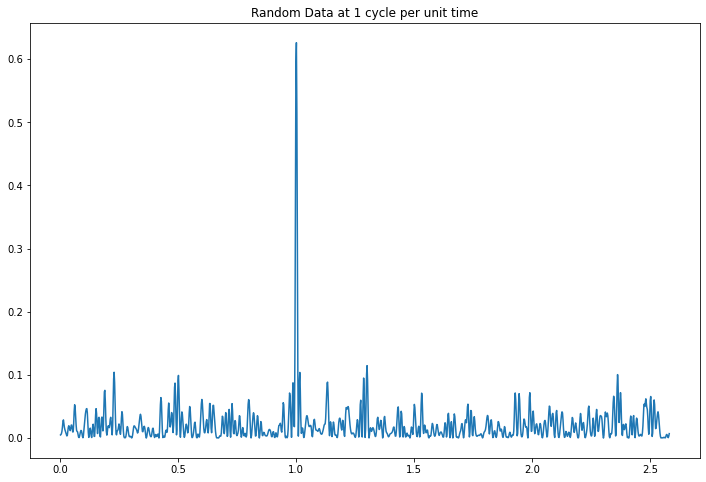

In [4]:
frequency, power = LS(t,y).autopower()
plt.figure(figsize=(12,8))
plt.plot(frequency, power)
plt.title('Random Data at 1 cycle per unit time')
plt.show()

Our periodogram shows a spike at 1 cycle per unit time. Expected, based on how we generated the data. We can easily change the value in sin function to give us a different dominant frequency. Here's a loop that increases that factor by one each time and creates a periodogram for each instance

In [5]:
f = []
p = []

for i in range(5):
    y1 = np.sin((i+1) * np.pi * t)
    frequency, power = LS(t,y1).autopower()
    f.append(frequency)
    p.append(power)

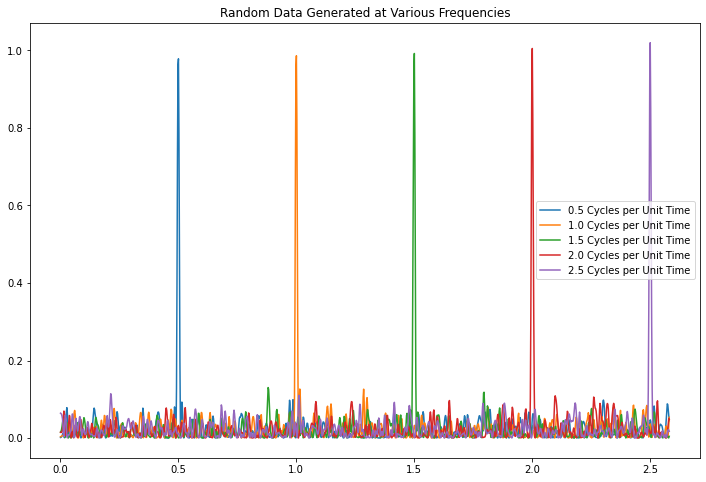

In [6]:
plt.figure(figsize=(12,8))
count = 0.5
for i in range(5):
    plt.plot(f[i], p[i], label = f'{count} Cycles per Unit Time')
    count += 0.5
plt.legend(loc='best')
plt.title('Random Data Generated at Various Frequencies')
plt.show()

## Measurement  Uncertainties
A scalar can be passed if all measurement uncertainties are equal. Or an array can be passed if they are on a per measurement basis.

In [7]:
# euncertainties (dy) are all equal
dy = 0.5
frequency, power = LS(t, y, dy).autopower()

In [8]:
# array of uncertainties
dy = 0.1 * (1 + rand.random(100))
y = np.sin(2 * np.pi * t) + dy * rand.standard_normal(100)
frequency, power = LS(t, y, dy).autopower()

## Units
LombScargle objects can handle units and will check to make sure they are being used appropriately.

In [9]:
import astropy.units as u

In [10]:
# add units
t_days = t * u.day
y_mags = y * u.mag
dy_mags = y * u.mag

# run LS
frequency, power = LS(t_days, y_mags, dy_mags).autopower()

In [11]:
frequency.unit

Unit("1 / d")

In [12]:
power.unit

Unit(dimensionless)

The power output is dimensionless in the above example. We can pass minimum and maximum frequency arguments to autopower, but need to include units if we do.

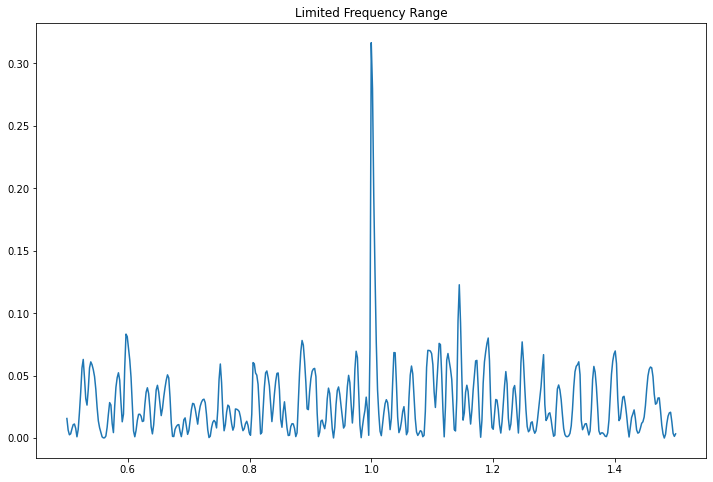

In [13]:
frequency, power = LS(t_days, y_mags, dy_mags).autopower(minimum_frequency=0.5/u.d, maximum_frequency=1.5/u.d)
plt.figure(figsize=(12,8))
plt.plot(frequency,power)
plt.title('Limited Frequency Range')
plt.show()

## Specifying Frequencies
Using autopower(), some assumptions are made:
* The width of the peaks are inversely proportional to the observation baseline
* Max frequency is a factor of five larger than the average Nyquist frequency

Autopower() parameters can be found here

https://docs.astropy.org/en/stable/api/astropy.timeseries.LombScargle.html#astropy.timeseries.LombScargle.autopower

The Nyquist factor is a float value that will be multiplied by the average nyquist frequency of the input data to determine the maximum frequency the periodogram is calculated at. If we inclrease the nyquist factor, we can probe higher frequencies. The default is 5. 

## Frequency Grid Spacing
We can pass a user defined array to calculate frequencies at. But if the grid is not evenly spaced, we can "miss" frequencies in the calculations. It's better to set the min and max frequencies through autopower()

## The Lomb-Scargle Model
Lomb-Scargle fits a sinusoidal model to the data at each frequency. The larger the power, the better the fit. The modeling section seems like it'd be useful to return to. For now though I can't get anything to run properly.

## Peak Significance and False Alarm Probabilities
This shit is really complicated. Will probably need to read these two links to understand it in depth. But I don't have time, so I'm gonna wing it.
* https://arxiv.org/pdf/1703.09824.pdf
* https://github.com/jakevdp/PracticalLombScargle/

We can determine the significance of a periodogram peak by expressing it in terms of a false alarm probability.

### Example
Start by simulating 60 observations of a sine wave with noise:

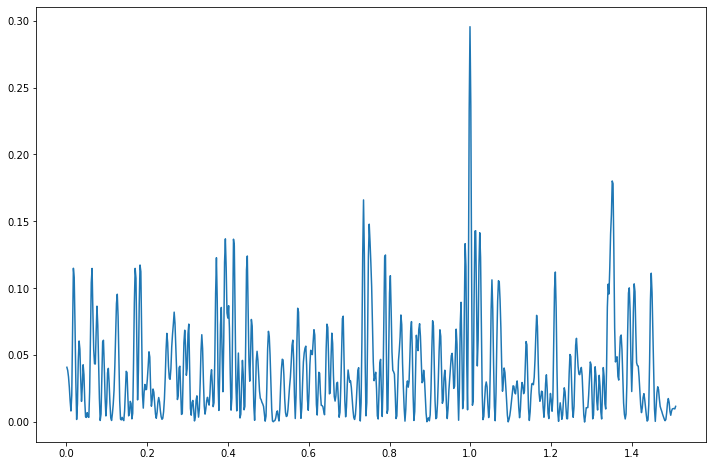

In [14]:
# generate time data
t = 100 * rand.random(60)
# error
dy = 1
# flux data
y = np.sin(2 * np.pi * t) + dy * rand.standard_normal(60)

# calculate Lomb Scargle
ls = LS(t, y, dy)
freq, power = ls.autopower()

# plot pg
plt.figure(figsize=(12,8))
plt.plot(freq, power)
plt.show()

In [15]:
# print max power
max_pwr = power.max()
print(max_pwr)

0.29549772541948066


How do we know how significant this peak is? We can use the false_alarm_probability() method.

https://docs.astropy.org/en/stable/api/astropy.timeseries.LombScargle.html#astropy.timeseries.LombScargle.false_alarm_probability

In [16]:
ls.false_alarm_probability(max_pwr) * 100

2.829281123426274

What this tells us is that under the assumption that there is no periodic signal in the data, we will observe a peak this high or higher approximately (above cell's percentage) of the time, which gives a strong indication that a periodic signal is present in the data.

Users must interpret this probability carefully: it is a measurement conditioned on the assumption of the null hypothesis of no signal; in symbols, you might write P(data∣noise−only).

Although it may seem like this quantity could be interpreted with a statement such as “there is an 0.4% chance that this data is noise only,” this is not a correct statement; in symbols, this statement describes the quantity P(noise−only∣data), and in general P(A∣B)≠P(B∣A).

Like I said earlier. This shit is complicated.

### false_alarm_level()
A method to compute the required peak height to obtain an input false alarm probability. Input the probability, the method outputs the required peak height.

In [17]:
ls.false_alarm_level(0.01)

array(0.32246591)

There are several estimation methods for computing the false alarm statistics. In general, we should use the bootstrap approach when computationally feasible, and the Baluev approach otherwise.

In all of this, it is important to keep in mind:
* False alarm probabilities are computed relative to a particular set of observing times, and a particular choice of frequency grid.
* False alarm probabilities are conditioned upon the null hypothesis of data with no periodic component, and in particular say nothing quantitative about whether the data are actually consistent with a periodic model.
* False alarm probabilities are not related to the question of whether the highest peak in a periodogram is the correct peak, and in particular are not especially useful in the case of observations with a strong aliasing pattern.

### Test and Demo of False Alarm Methods
The goal is to generate data that gets progressivelly more noise, and to see how the false alarm methods respond to that noise.
I'm going to try it with the bootstrap and Baluev approach.

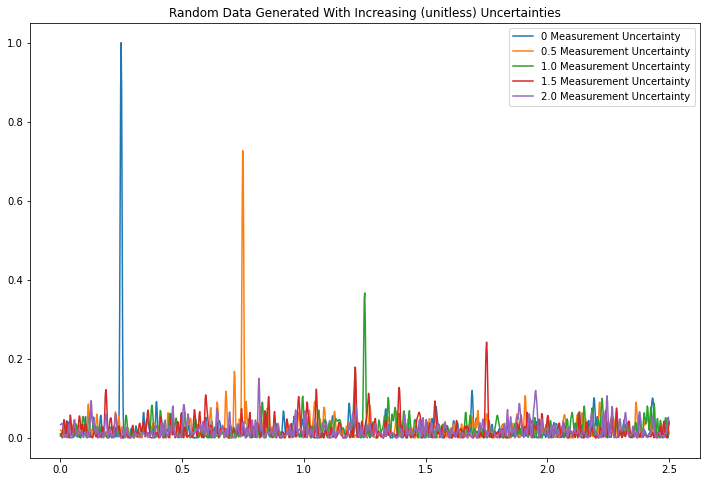

In [18]:
# initial error
dy = 0

# flux and power data
f = []
p = []
for i in range(5):
    t = 100 * rand.random(100)
    y = np.sin((i+0.5) * np.pi * t) + dy * rand.standard_normal(100)
    frequency, power = LS(t,y).autopower(maximum_frequency=2.5)
    f.append(frequency)
    p.append(power)
    dy += 0.5

# plot everything
plt.figure(figsize=(12,8))
count = 0
for i in range(5):
    plt.plot(f[i], p[i], label = f'{count} Measurement Uncertainty')
    count += 0.5
plt.legend(loc='best')
plt.title('Random Data Generated With Increasing (unitless) Uncertainties')
plt.show()

There is probably a clearer way to make this graph. Maybe normalizing the highest peak of all plots to one? Regardless, we can see that as the uncertainty increases, the highest point of the peak gets closer to the noise floor of the data as the . The other way to think of this is that the noise is increasing as our uncertainties increase.

### A note on the function parameters
The bootstrap method is too computationally expensive, it crashes the notebooks everytime. The other three method could be used and averaged together to get a good idea of the probability maybe?

Next I'll write a loop that calculates the false alarm probabilities on periodograms with increasing measurement errors.

In [19]:
ls = LS(t, y, dy)
freq, power = ls.autopower()

In [20]:
# array of errors to calculate at
error = np.arange(0,3.1,0.001)

# flux and power data
f = []
p = []
pwr = []
false_prob = []

for i in error:
    # generate time data
    t = 100 * rand.random(100)
    
    # generate flux data with dominant frequency at 1 Hz
    y = np.sin(2 * np.pi * t) + i * rand.standard_normal(100)
    
    # calculate Lomb Scargle
    ls = LS(t, y, i)
    frequency, power = ls.autopower()
    
    # append frequency and power to lists
    f.append(frequency)
    p.append(power)
    
    # calculate & append max power
    max_pwr = power.max()
    pwr.append(max_pwr)
    
    # calculate false alarm probability at max power
    probability = ls.false_alarm_probability(max_pwr) * 100
    false_prob.append(probability)

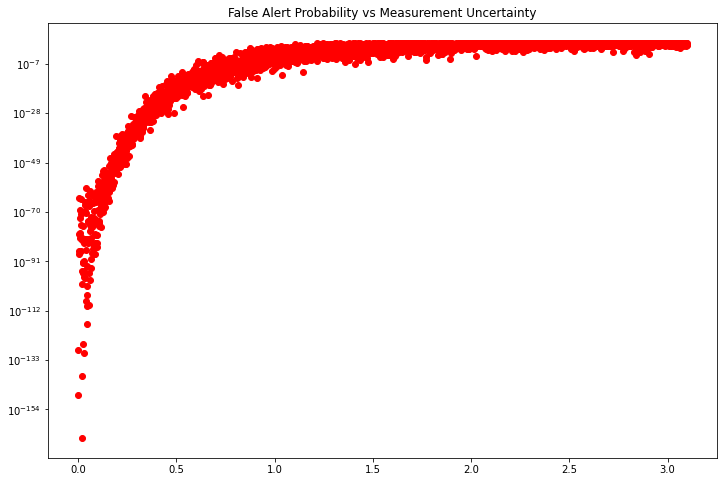

In [21]:
plt.figure(figsize=(12,8))
plt.plot(error, false_prob, 'o', color='r')
plt.title('False Alert Probability vs Measurement Uncertainty')
#plt.xscale('log')
plt.yscale('log')
plt.show()

If I did this right (there's a good chance I didn't) this graph shows our probability of a false positive increasing as the measurement uncertainty approaches 1. I don;t know if that's because our dominant frequency is 1 Hz though. I'll try below and set the dominant frequency to 1.5 Hz

## RR Lyrae Example
An example of computing the periodogram for a more realistic dataset is shown in the following figure. The data here consists of 50 nightly observations of a simulated RR Lyrae-like variable star, with a lightcurve shape that is more complicated than a simple sine wave:

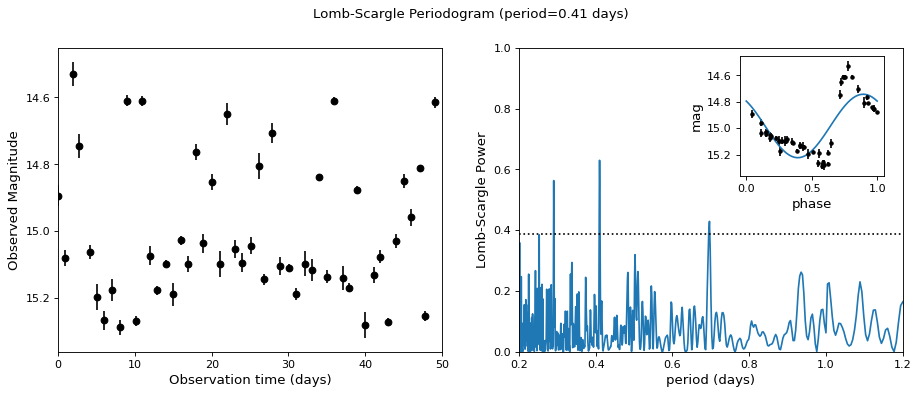

The dotted line shows the periodogram level corresponding to a maximum peak false alarm probability of 1%. This example demonstrates that for irregularly sampled data, the Lomb-Scargle periodogram can be sensitive to frequencies higher than the average Nyquist frequency: the above data are sampled at an average rate of roughly one observation per night, and the periodogram relatively cleanly reveals the true period of 0.41 days.

Still, the periodogram has many spurious peaks, which are due to several factors:

Errors in observations lead to leakage of power from the true peaks.

The signal is not a perfect sinusoid, so additional peaks can indicate higher frequency components in the signal.

The observations take place only at night, meaning that the survey window has non-negligible power at a frequency of 1 cycle per day. Thus we expect aliases to appear at falias=ftrue+nfwindow for integer values of n. With a true period of 0.41 days and a 1-day signal in the observing window, the n=+1 and n=−1 aliases to lie at periods of 0.29 and 0.69 days, respectively: these aliases are prominent in the above plot.

The interaction of these effects means that in practice there is no absolute guarantee that the highest peak corresponds to the best frequency, and results must be interpreted carefully. For a detailed discussion of these effects, see https://arxiv.org/pdf/1703.09824.pdf

### Info from Jamie on This
In terms of the opinions of the False Alarm probability, it's a pretty standard tool in the field. It's probably therefore generically true that people are not as careful with it as they ought to be, especially when they try to use it to say one tiny peak is real (e.g. a planet orbital period detection, which I think is closer to the complaint detailed in the article). You're using it for something slightly closer to what it's designed for, given a set of detected peaks, what's the probability that a peak of that height and frequency could have arisen just from random errors in the dataset given the observed points, their numbers, errors, and spacing, etc. It's reasonable to think about how conservative to be (if you test 100 peaks, using a 2 sigma threshold is going to let in five just from noise, so you probably want something stricter) but I don't think something more sophisticated is going to give you a radically different answer, and it will take a lot more work (jackknife sampling, bootstrapping, etc). You also want to be careful that a 5% chance that the peak could have arisen from noise is not actually the same thing as a 95% chance that it's real (see conditional probability, Bayes theorem, etc) but again, that's one of those rather pedantic points that might matter if we were trying to quantify each peak, but we're really more interested in a 'likely real' or 'likely noise' sort of metric, and I don't think we'll be that far off just using the false alarm probability in the standard way. 